# Test de plusieur modèles et recherche du meilleur modèle pour interprétation des meilleurs "Features"

## Importation des libraires

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
pd.set_option("display.max_rows",100)  
pd.set_option("display.max_columns",None)
warnings.filterwarnings('ignore')

# check version number
import imblearn
print("imblearn version :", imblearn.__version__)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

imblearn version : 0.8.0


## Création des fonctions

In [2]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

def repartition_dataset(data,target,test_size=0.2,random_state=0,stratify_target=True,under_sampling=False,over_sampling=False):
    if stratify_target:
        train_set,test_set = train_test_split(data,test_size=test_size,random_state=random_state,stratify=data[target])
    else:
        train_set,test_set = train_test_split(data,test_size=test_size,random_state=random_state)
        
    # test set
    X_test = test_set.drop(target,axis=1)
    y_test = test_set[[target]]
    print("Test =>\nX :", X_test.shape, "\ny :",y_test.shape)
    if under_sampling :
        train_set = fair_data(train_set,target)
    X_train = train_set.drop(target,axis=1)
    y_train = train_set[[target]]
    
    if over_sampling :
        over = SMOTE(sampling_strategy=0.1)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        X_train, y_train = pipeline.fit_resample(X_train, y_train)
    
    print("Train =>\nX :", X_train.shape, "\ny :",y_train.shape)
    
    return X_train,X_test,y_train,y_test

# Fonctionne avec des données binaire, méthode de downsample ou undersampling
def fair_data(data,target,random_state=0):
    positif_data = data[data[target]==1]
    negatif_data = data[data[target]==0]
    min_size = min([positif_data.shape[0],negatif_data.shape[0]])
    return pd.concat([positif_data.sample(min_size,random_state=random_state),
                      negatif_data.sample(min_size,random_state=random_state)], axis=0)

In [3]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

def plot_precision_recall_curve(y_pred_proba,y_test,figsize=(12,10)):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)  
    plt.figure(figsize=figsize)
    plt.title("Precision-Recall vs Threshold Chart")
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.ylabel("Precision, Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1])
    plt.show()
    
def plot_learning_curve(model,X_train,y_train,scoring=ftwo_scorer,cv=4,size_train=None):
    if size_train is None:
        N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                   cv=cv, scoring=scoring,
                                                   train_sizes=np.linspace(0.1, 1, 10))
    else:
        N, train_score, val_score = learning_curve(model, X_train[:size_train], y_train[:size_train],
                                                   cv=cv, scoring=scoring,
                                                   train_sizes=np.linspace(0.1, 1, 10))
        
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()

def plot_all_roc_curve(all_model,X_test,y_test,figsize=(9,7),title_roc_curve="ROC Curve",naive_model=None):
    fig, ax = plt.subplots(figsize=figsize)
    model_displays = {}
    for name, pipeline in all_model.items():
        model_displays[name] = plot_roc_curve(pipeline, X_test, y_test, ax=ax, name=name)
        
    if not naive_model is None:
        model_displays["Naive"] = plot_roc_curve(naive_model, X_test, y_test, ax=ax, name="Naive")
        
    _ = ax.set_title(title_roc_curve)
        

def evaluation(model,X_test,y_test):
    y_pred = model.predict(X_test)
    print("Matrice confusion :\n",confusion_matrix(y_test,y_pred))
    score = ftwo_scorer(model,X_test,y_test)
    print("Score (fbeta 2):",score )
    return score
   

## Récupération du jeu de données

In [4]:
df_knowledge_domain = pd.read_feather("./final_dataset/knowledge_domain").drop("index",axis=1)

In [102]:
df_knowledge_domain.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS,BASEMENTAREA,YEARS_BEGINEXPLUATATION,YEARS_BUILD,COMMONAREA,ELEVATORS,ENTRANCES,FLOORSMAX,FLOORSMIN,LANDAREA,LIVINGAPARTMENTS,LIVINGAREA,NONLIVINGAPARTMENTS,NONLIVINGAREA,TOTALAREA,FLAG_WORK,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZAT

In [5]:
round(df_knowledge_domain["TARGET"].value_counts(normalize=True)*100,3)

0    91.925
1     8.075
Name: TARGET, dtype: float64

In [6]:
# On garde que 1% du dataset pour faire des tests rapide
_,new_little_dataset = train_test_split(df_knowledge_domain,stratify=df_knowledge_domain["TARGET"],test_size=0.01,random_state=0)
print("Dimensionnalité du dataset :",new_little_dataset.shape)

Dimensionnalité du dataset : (3073, 218)


In [7]:
round(new_little_dataset["TARGET"].value_counts(normalize=True)*100,3)

0    91.93
1     8.07
Name: TARGET, dtype: float64

On récupère la même proportion du dataset sur la variable Target.

In [8]:
X_train,X_test,y_train,y_test = repartition_dataset(new_little_dataset,"TARGET")

Test =>
X : (615, 217) 
y : (615, 1)
Train =>
X : (2458, 217) 
y : (2458, 1)


# Feature selection (Boruta)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

def boruta_feature_selection(trainset, target, verbose=0,sample=None,random_state=0):
    
    # Création de la randomforest pour l'utilisation de boruta
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=verbose, random_state=random_state)
    # split train
    if sample!=None:
        trainset = trainset.sample(sample,random_state=random_state)
        
    X = trainset.drop(target,axis=1).values
    feature = np.array(trainset.drop("TARGET",axis=1).columns.tolist())
    y = trainset[["TARGET"]].values
    y = y.ravel()
    feat_selector.fit(X, y)
    
    return feat_selector , feature, X, y

In [14]:
feat_selector, feature, X, y = boruta_feature_selection(df_knowledge_domain,"TARGET")

In [15]:
new_feature_boruta = [col for col in feature[feat_selector.support_]]

In [16]:
def transformer_boruta(X):
    return X[new_feature_boruta]

In [17]:
X_train_init = X_train.copy()
X_test_init = X_test.copy()
X_train = transformer_boruta(X_train)
X_test = transformer_boruta(X_test)

# Baseline NAIVE (répartition uniforme aléatoire)

In [18]:
## NAIVE
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform",random_state=42)
dummy_clf.fit(X_train,y_train)

store_score = {}
store_score["Naive"] = evaluation(dummy_clf,X_test,y_test)

Matrice confusion :
 [[271 294]
 [ 22  28]]
Score (fbeta 2): 0.2681992337164751


## Création d'un transformateur personnalisé

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Permet de diminuer le temps de traitement en appliquant le polynomial feature seulement sur les n_best
class Personal_transformer(BaseEstimator,TransformerMixin):

    def __init__(self,degree=2,include_biais=False,n_best=10,select_method=f_classif):
        self.degree=degree
        self.include_biais=include_biais
        self.n_best=n_best
        self.select_method = select_method
        self.polynomial_transformer=PolynomialFeatures(degree, include_bias=include_biais)
        self.selector = SelectKBest(select_method,k=n_best)
        self.feature_transform_ = []
        self.feature_selected_= []
        self.other_feature_ = []

    def fit(self,X,y=None):
        self.selector.fit(X,y)
        self.feature_selected_ = X.columns[self.selector.get_support()]
        self.other_feature_ = [col for col in X.columns if not col in self.feature_selected_]
        self.polynomial_transformer.fit(X[self.feature_selected_])
        self.feature_transform_ = self.polynomial_transformer.get_feature_names(self.feature_selected_)
        return self
        
    def transform(self,X,y=None):
        X_poly = self.polynomial_transformer.transform(X[self.feature_selected_])
        new_X = np.hstack([X_poly, X[self.other_feature_]])
        return new_X
    
    def fit_transform(self,X,y=None):
        self.selector.fit(X,y)
        self.feature_selected_ = X.columns[self.selector.get_support()]
        self.other_feature_ = [col for col in X.columns if not col in self.feature_selected_]
        X_poly = self.polynomial_transformer.fit_transform(X[self.feature_selected_])
        self.feature_transform_ = self.polynomial_transformer.get_feature_names(self.feature_selected_)
        new_X = np.hstack([X_poly, X[self.other_feature_]])
        return new_X
    
    def get_new_feature(self):
        new_feature = self.feature_transform_.copy()
        new_feature.extend(self.other_feature_.copy())
        return new_feature

# Réalisation des différents test 

## 1) 1% dataset, sans preprocessing (sauf la standardisation) et avec le jeu de données feature boruta 

In [20]:
from sklearn.pipeline import make_pipeline

preprocessor = make_pipeline(Personal_transformer())

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

RandomForest = make_pipeline(RandomForestClassifier(random_state=0,n_jobs=50,class_weight="balanced"))
AdaBoost = make_pipeline(AdaBoostClassifier(random_state=0))
# SVM = make_pipeline(StandardScaler(), SVC(random_state=0,probability=True)) # Trop compliqué dans le contexte global (avec tous le jeu de données)
Logistic_regression = make_pipeline(StandardScaler(), LogisticRegression(random_state=0,class_weight="balanced"))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [21]:
dic_model = {
    "RandomForest":RandomForest, 
    "AdaBoost":AdaBoost,
#     "SVM":SVM,
    "LogisticRegression":Logistic_regression,
    "KNN":KNN
}

In [22]:
dic_params= {
    "RandomForest":{
        "randomforestclassifier__class_weight":['balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200],
    }, 
    "AdaBoost":{
        "adaboostclassifier__n_estimators":[50,100,150,200],
        "adaboostclassifier__learning_rate": [0.5,1.0,1.5,2.0],
    },
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": ['balanced'],
        "logisticregression__penalty":["l1","l2"],
    },
    "KNN":{
        "kneighborsclassifier__n_neighbors":[3,5,7,9,11,13,15,17,19,21],
    }
}

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

RandomForest
Best params :
 {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}
Best score CV : 0.29776250274876426
Matrice confusion :
 [[501  64]
 [ 35  15]]
Score (fbeta 2): 0.26881720430107525


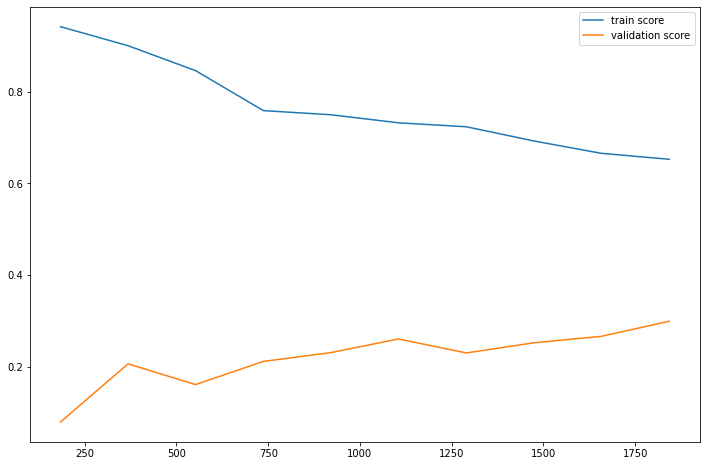

AdaBoost
Best params :
 {'adaboostclassifier__learning_rate': 2.0, 'adaboostclassifier__n_estimators': 50}
Best score CV : 0.24234445045211625
Matrice confusion :
 [[ 23 542]
 [  4  46]]
Score (fbeta 2): 0.2918781725888325


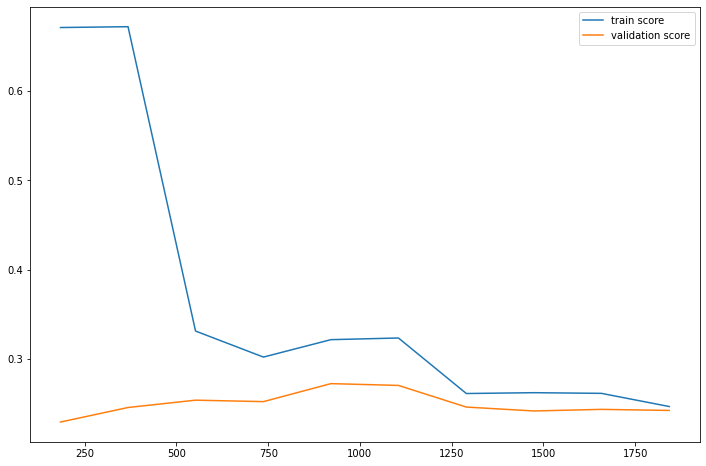

LogisticRegression
Best params :
 {'logisticregression__C': 0.000774263682681127, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}
Best score CV : 0.3918167824016153
Matrice confusion :
 [[403 162]
 [ 22  28]]
Score (fbeta 2): 0.358974358974359


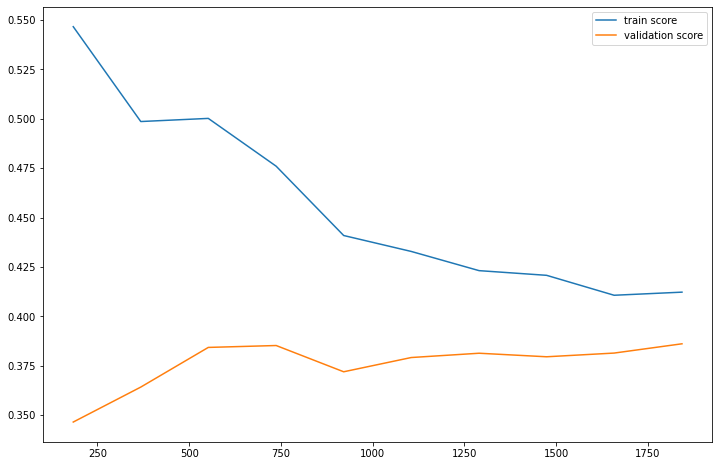

KNN
Best params :
 {'kneighborsclassifier__n_neighbors': 3}
Best score CV : 0.02990430622009569
Matrice confusion :
 [[554  11]
 [ 48   2]]
Score (fbeta 2): 0.046948356807511735


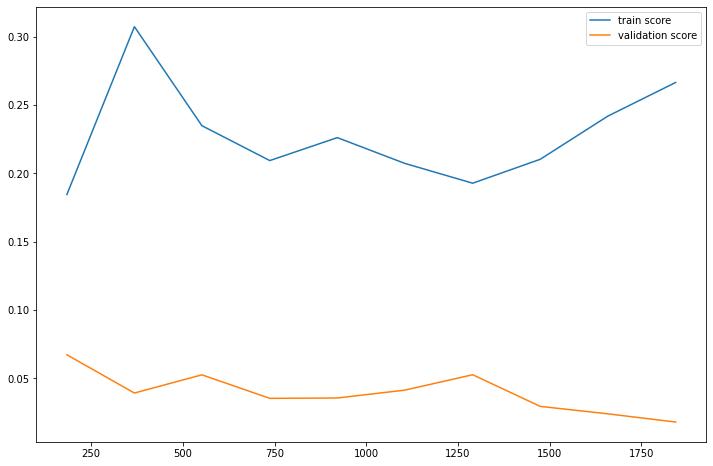

Wall time: 30.7 s


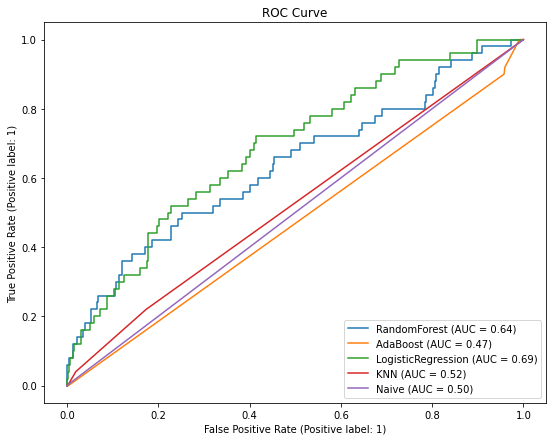

In [24]:
%%time
dic_best_model = {}

for name, model in dic_model.items():
    print(name)
    grid = GridSearchCV(model,dic_params[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model,X_test,y_test,naive_model=dummy_clf)

In [25]:
store_score

{'Naive': 0.2681992337164751,
 'RandomForest': 0.26881720430107525,
 'AdaBoost': 0.2918781725888325,
 'LogisticRegression': 0.358974358974359,
 'KNN': 0.046948356807511735}

Ici on obtien de bon résultat sur **la Logisitc régression** avec un score de 0.36

On remarque aussi que pour le **RandomForest** il est possible d'augmenter considérablement le score en augmentant la taille du jeu de donnée d'entrainement.

## 1.1) 1% dataset, avec preprocessing perso et avec le jeu de données initial

RandomForest
Best params :
 {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 50}
Best score CV : 0.284682786364451
Matrice confusion :
 [[508  57]
 [ 36  14]]
Score (fbeta 2): 0.25830258302583026


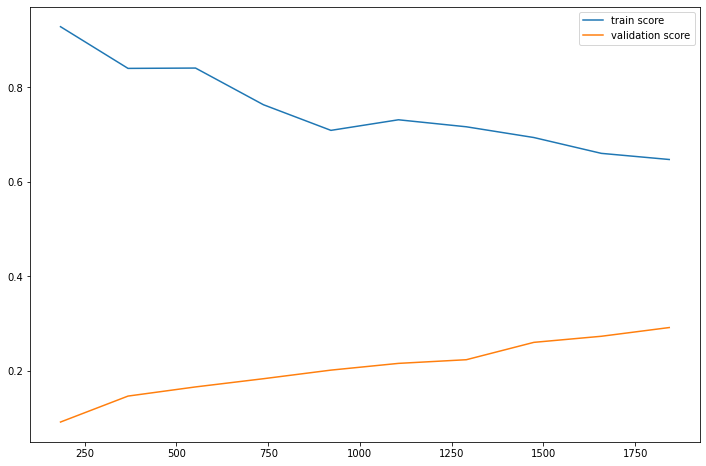

AdaBoost
Best params :
 {'adaboostclassifier__learning_rate': 2.0, 'adaboostclassifier__n_estimators': 50}
Best score CV : 0.24234445045211625
Matrice confusion :
 [[ 23 542]
 [  4  46]]
Score (fbeta 2): 0.2918781725888325


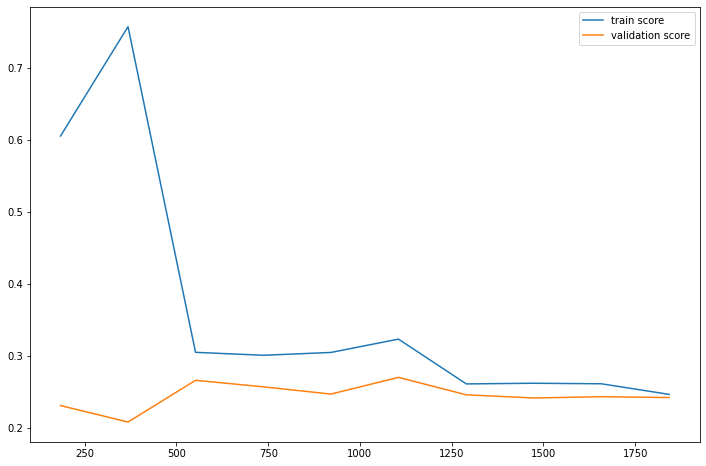

LogisticRegression
Best params :
 {'logisticregression__C': 0.0001, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}
Best score CV : 0.3515018523425257
Matrice confusion :
 [[401 164]
 [ 22  28]]
Score (fbeta 2): 0.35714285714285715


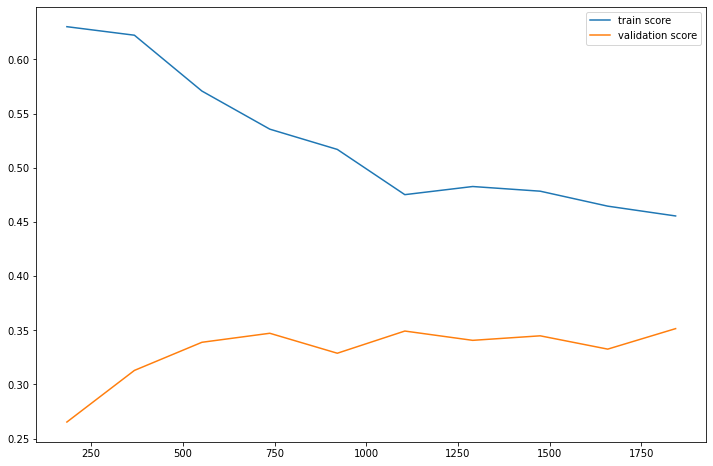

KNN
Best params :
 {'kneighborsclassifier__n_neighbors': 3}
Best score CV : 0.03608783958309629
Matrice confusion :
 [[556   9]
 [ 49   1]]
Score (fbeta 2): 0.023809523809523808


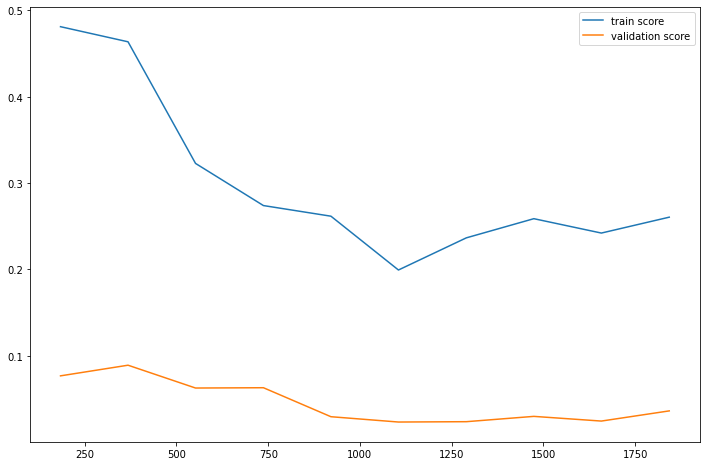

Wall time: 34.1 s


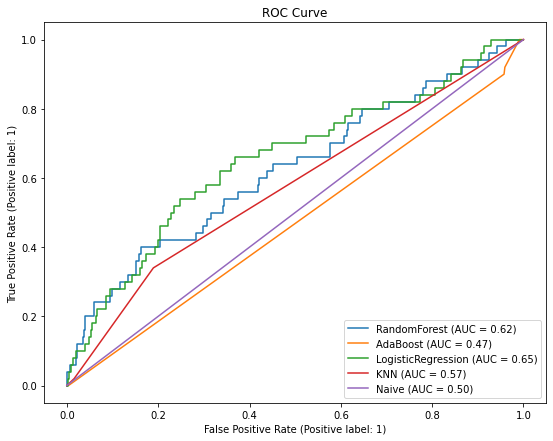

In [26]:
%%time
dic_best_model_1 = {}
store_score_1 ={}
for name, model in dic_model.items():
    print(name)
    grid = GridSearchCV(model,dic_params[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train_init,y_train)
    dic_best_model_1[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_1[name] = evaluation(grid.best_estimator_,X_test_init,y_test)
    plot_learning_curve(grid.best_estimator_,X_train_init,y_train)

plot_all_roc_curve(dic_best_model_1,X_test_init,y_test,naive_model=dummy_clf)

In [27]:
store_score_1

{'RandomForest': 0.25830258302583026,
 'AdaBoost': 0.2918781725888325,
 'LogisticRegression': 0.35714285714285715,
 'KNN': 0.023809523809523808}

Sur cette configuration on remarque que les modèles **LogisticRegression et RandomForest** sont toujours les plus interresants, cependant **les résultats semble moins intéressant que sur le jeu de données sélectionner avec la méthode Boruta.**

## 2) 1% dataset, avec preprocessing perso et avec le jeu de données feature boruta 

In [28]:
# Preprocessor
preprocessor = make_pipeline(Personal_transformer())

# pipeline
RandomForest_2 = make_pipeline(preprocessor, RandomForestClassifier(random_state=0,n_jobs=50,class_weight="balanced"))
AdaBoost_2 = make_pipeline(preprocessor,AdaBoostClassifier(random_state=0))
Logistic_regression_2 = make_pipeline(preprocessor,StandardScaler(), LogisticRegression(random_state=0,class_weight="balanced"))
KNN_2 = make_pipeline(preprocessor,StandardScaler(), KNeighborsClassifier())

dic_model_2 = {
    "RandomForest":RandomForest_2, 
    "AdaBoost":AdaBoost_2,
    "LogisticRegression":Logistic_regression_2,
    "KNN":KNN_2
}

In [29]:
dic_params_2 = {
    "RandomForest":{
        "randomforestclassifier__class_weight":['balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200],
        "pipeline__personal_transformer__degree":[1,2,3],
        "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    }, 
    "AdaBoost":{
        "adaboostclassifier__n_estimators":[50,100,150,200],
        "adaboostclassifier__learning_rate": [0.5,1.0,1.5,2.0],
        "pipeline__personal_transformer__degree":[1,2,3],
        "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    },
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": ['balanced'],
        "logisticregression__penalty":["l1","l2"],
        "pipeline__personal_transformer__degree":[1,2,3],
        "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    },
    "KNN":{
        "kneighborsclassifier__n_neighbors":[3,5,7,9,11,13,15,17,19,21],
        "pipeline__personal_transformer__degree":[2,3],
        "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    }
}

RandomForest
Best params :
 {'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 150}
Best score CV : 0.2966977743735853
Matrice confusion :
 [[503  62]
 [ 36  14]]
Score (fbeta 2): 0.2536231884057972


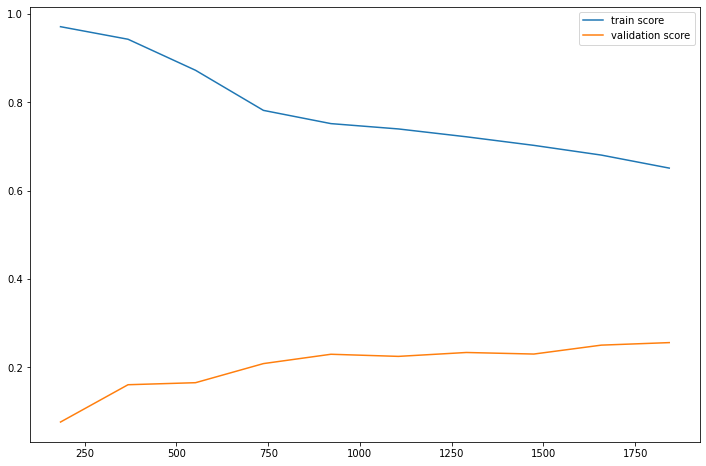

AdaBoost
Best params :
 {'adaboostclassifier__learning_rate': 2.0, 'adaboostclassifier__n_estimators': 50, 'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.23367685353501894
Matrice confusion :
 [[ 23 542]
 [  4  46]]
Score (fbeta 2): 0.2918781725888325


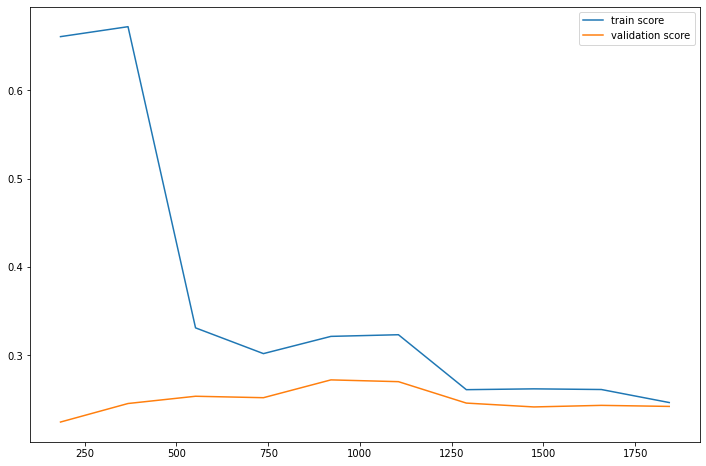

LogisticRegression
Best params :
 {'logisticregression__C': 0.0001, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.3960838508486617
Matrice confusion :
 [[382 183]
 [ 22  28]]
Score (fbeta 2): 0.340632603406326


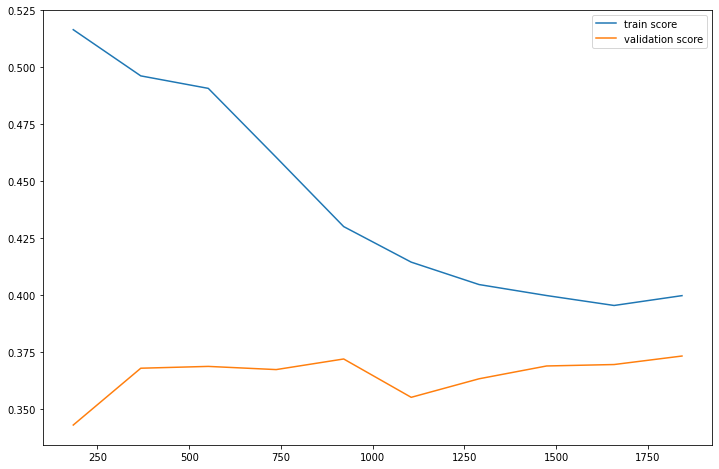

KNN
Best params :
 {'kneighborsclassifier__n_neighbors': 3, 'pipeline__personal_transformer__degree': 2, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.058796173266011165
Matrice confusion :
 [[555  10]
 [ 47   3]]
Score (fbeta 2): 0.07042253521126761


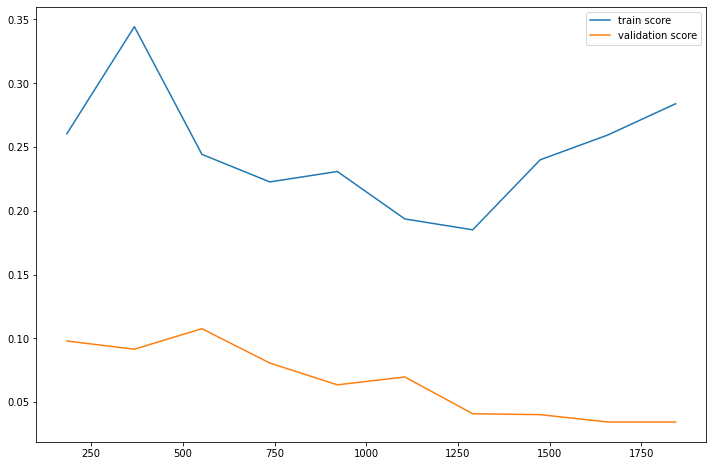

Wall time: 1min 40s


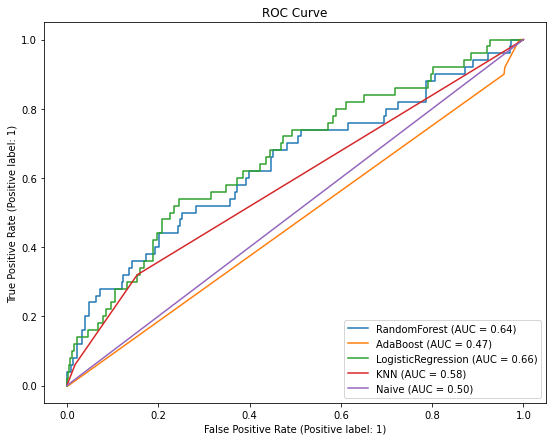

In [30]:
%%time
dic_best_model_2 = {}
store_score_2 ={}

for name, model in dic_model_2.items():
    print(name)
    grid = GridSearchCV(model,dic_params_2[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model_2[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_2[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model_2,X_test,y_test,naive_model=dummy_clf)

In [31]:
store_score_2

{'RandomForest': 0.2536231884057972,
 'AdaBoost': 0.2918781725888325,
 'LogisticRegression': 0.340632603406326,
 'KNN': 0.07042253521126761}

Le preprocessing ne semblent pas le plus adaptée à la situation ici, le score diminue avec la mise en place du preprocessing personnel (Transformer_perso).

## 2.1) 1% dataset, avec preprocessing perso et avec le jeu de données initial

RandomForest
Best params :
 {'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}
Best score CV : 0.32137279739496505
Matrice confusion :
 [[507  58]
 [ 35  15]]
Score (fbeta 2): 0.2747252747252747


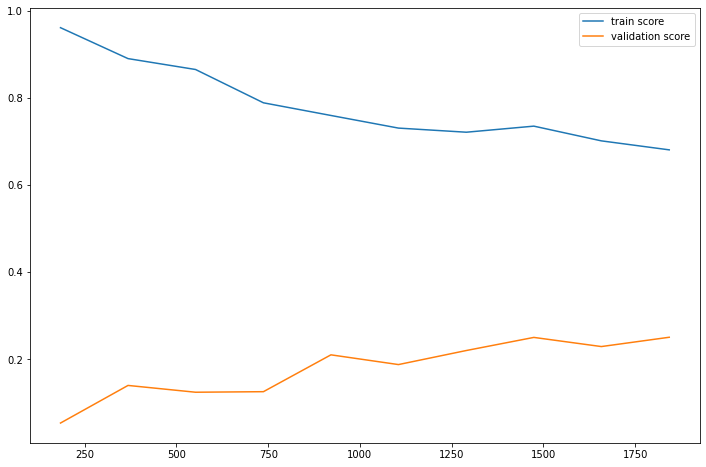

AdaBoost
Best params :
 {'adaboostclassifier__learning_rate': 2.0, 'adaboostclassifier__n_estimators': 50, 'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.23367685353501894
Matrice confusion :
 [[ 23 542]
 [  4  46]]
Score (fbeta 2): 0.2918781725888325


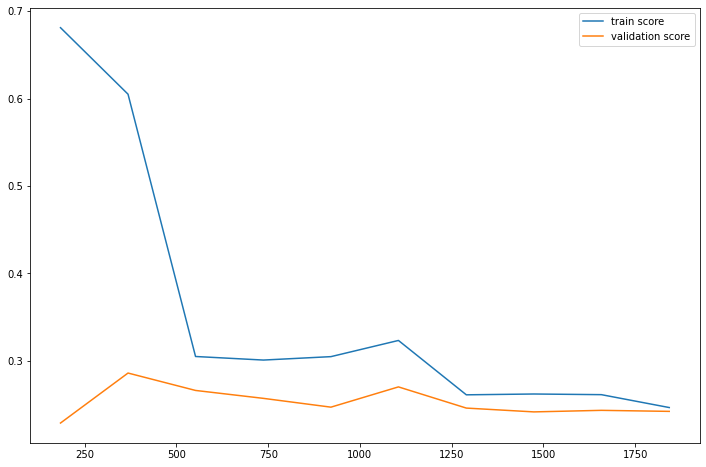

LogisticRegression
Best params :
 {'logisticregression__C': 0.0001, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.3640284323172766
Matrice confusion :
 [[401 164]
 [ 22  28]]
Score (fbeta 2): 0.35714285714285715


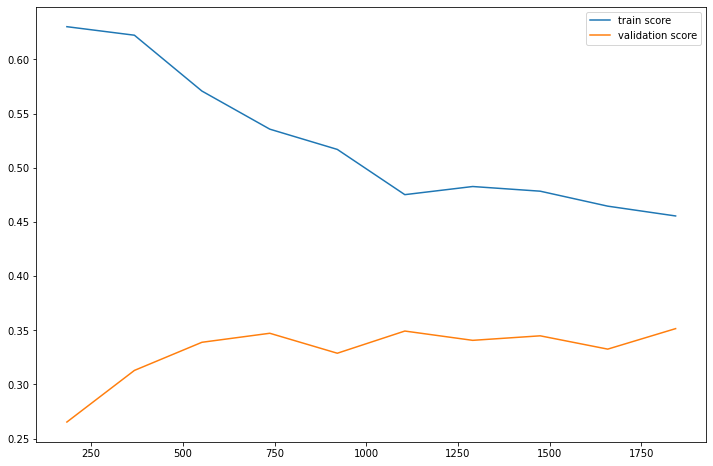

KNN
Best params :
 {'kneighborsclassifier__n_neighbors': 3, 'pipeline__personal_transformer__degree': 2, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.06960106234381325
Matrice confusion :
 [[553  12]
 [ 50   0]]
Score (fbeta 2): 0.0


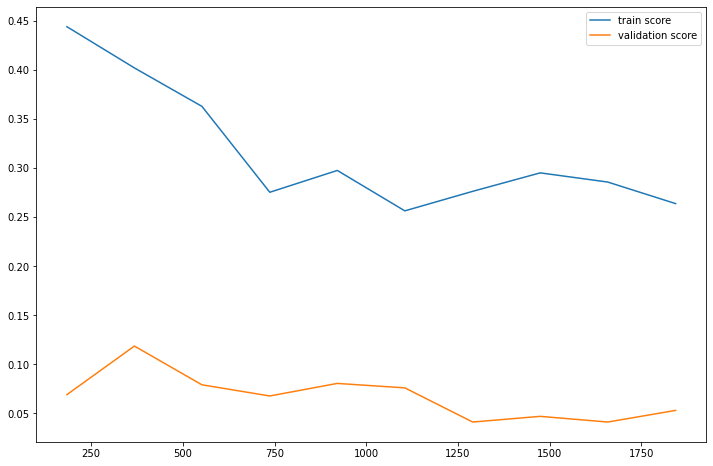

Wall time: 2min 4s


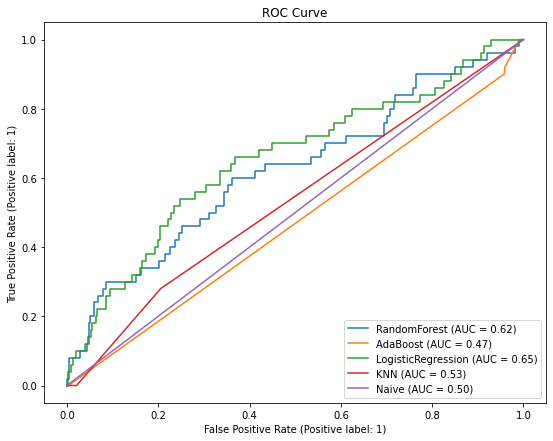

In [32]:
%%time
dic_best_model_2_1 = {}
store_score_2_1 ={}

for name, model in dic_model_2.items():
    print(name)
    grid = GridSearchCV(model,dic_params_2[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train_init,y_train)
    dic_best_model_2_1[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_2_1[name] = evaluation(grid.best_estimator_,X_test_init,y_test)
    plot_learning_curve(grid.best_estimator_,X_train_init,y_train)

plot_all_roc_curve(dic_best_model_2_1,X_test_init,y_test,naive_model=dummy_clf)

In [33]:
store_score_2_1

{'RandomForest': 0.2747252747252747,
 'AdaBoost': 0.2918781725888325,
 'LogisticRegression': 0.35714285714285715,
 'KNN': 0.0}

Ici même constat, le preprocessing ne semble pas pertinent, il augmente les résutlats du RandomForest par rapport au preprocessing sur le jeu de donnée boruta mais cela ne semble pas pertinent d'utiliser cette méthode de préprocessing.

On peut également en déduire que le random forest est meilleur avec seulement les donnée de boruta (ce qui semble logique), pour la régression logistique il semble qu'il sois nécessaire d'avoir le jeu de donnée initial pour être le plus performant possible, ( voir ajouter du preprocessing )

> Pour la suite on peut supprimer l'adaBoost et le KNN qui ne semble pas les meilleurs options pour notre problème.

## 3) 1% du dataset, PolynomialFeature pour le preprocessing, et Boruta feature

In [34]:
# Preprocessor
preprocessor_3 = make_pipeline(PolynomialFeatures(include_bias=False))

# pipeline
RandomForest_3 = make_pipeline(preprocessor_3, RandomForestClassifier(random_state=0,n_jobs=50,class_weight="balanced"))
Logistic_regression_3 = make_pipeline(preprocessor_3,StandardScaler(), LogisticRegression(random_state=0,class_weight="balanced"))

dic_model_3 = {
    "RandomForest":RandomForest_3, 
    "LogisticRegression":Logistic_regression_3,
}

In [35]:
dic_params_3 = {
    "RandomForest":{
        "randomforestclassifier__class_weight":['balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200],
        "pipeline__polynomialfeatures__degree":[1,2,3]
    }, 
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": ['balanced'],
        "logisticregression__penalty":["l1","l2"],
        "pipeline__polynomialfeatures__degree":[1,2,3]
    }
}

RandomForest
Best params :
 {'pipeline__polynomialfeatures__degree': 2, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 50}
Best score CV : 0.32185354368865393
Matrice confusion :
 [[518  47]
 [ 37  13]]
Score (fbeta 2): 0.25000000000000006


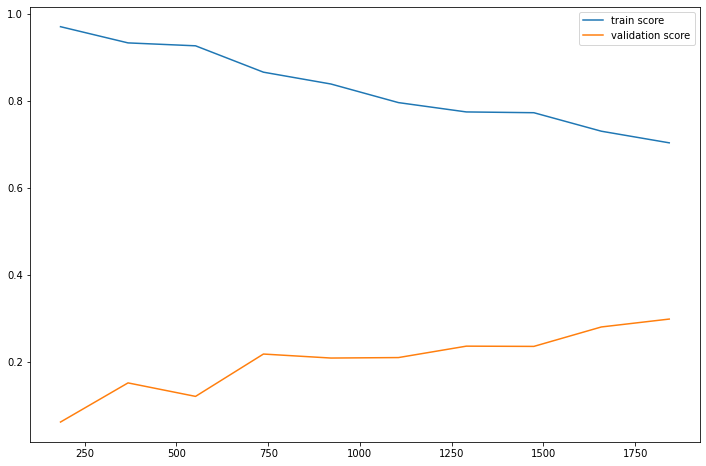

LogisticRegression
Best params :
 {'logisticregression__C': 0.000774263682681127, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'pipeline__polynomialfeatures__degree': 1}
Best score CV : 0.3918167824016153
Matrice confusion :
 [[403 162]
 [ 22  28]]
Score (fbeta 2): 0.358974358974359


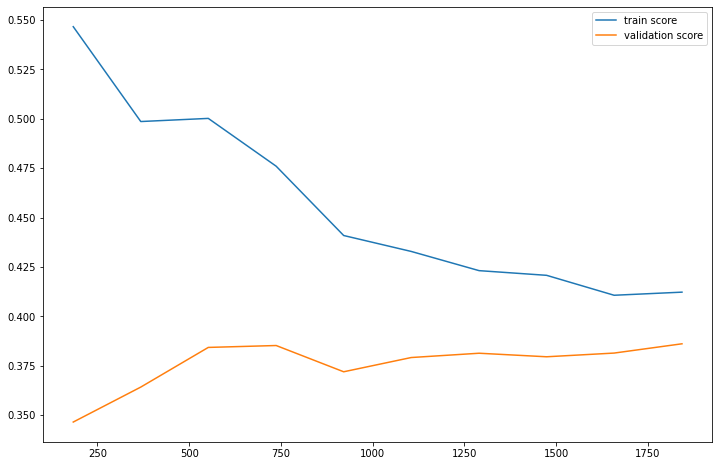

Wall time: 3min 24s


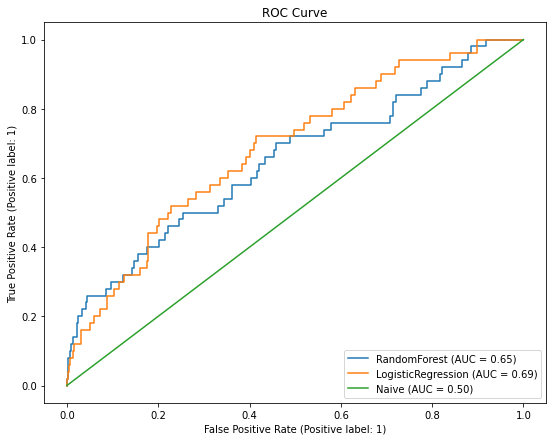

In [36]:
%%time
dic_best_model_3 = {}
store_score_3 ={}

for name, model in dic_model_3.items():
    print(name)
    grid = GridSearchCV(model,dic_params_3[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model_3[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_3[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model_3,X_test,y_test,naive_model=dummy_clf)

In [37]:
store_score_3

{'RandomForest': 0.25000000000000006, 'LogisticRegression': 0.358974358974359}

Cette solution dégrade les résultats avec le jeu de données boruta...

## 3.1) 1% du dataset, PolynomialFeature pour le preprocessing, et Initial feature

RandomForest
Best params :
 {'pipeline__polynomialfeatures__degree': 2, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 50}
Best score CV : 0.30247385448600583
Matrice confusion :
 [[513  52]
 [ 34  16]]
Score (fbeta 2): 0.29850746268656714


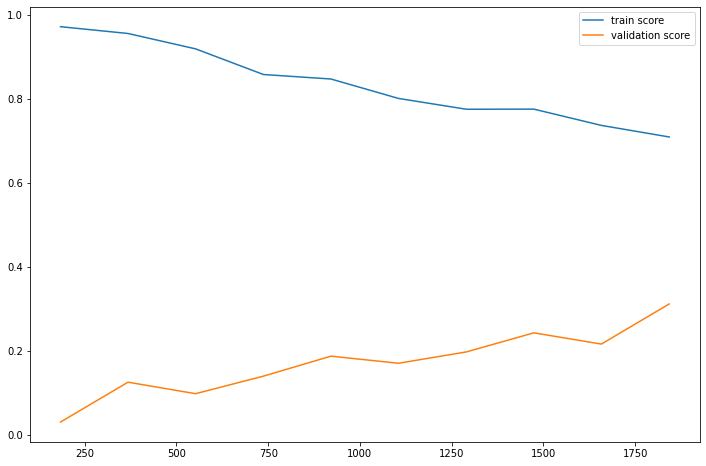

LogisticRegression
Best params :
 {'logisticregression__C': 0.0001, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'pipeline__polynomialfeatures__degree': 1}
Best score CV : 0.3515018523425257
Matrice confusion :
 [[401 164]
 [ 22  28]]
Score (fbeta 2): 0.35714285714285715


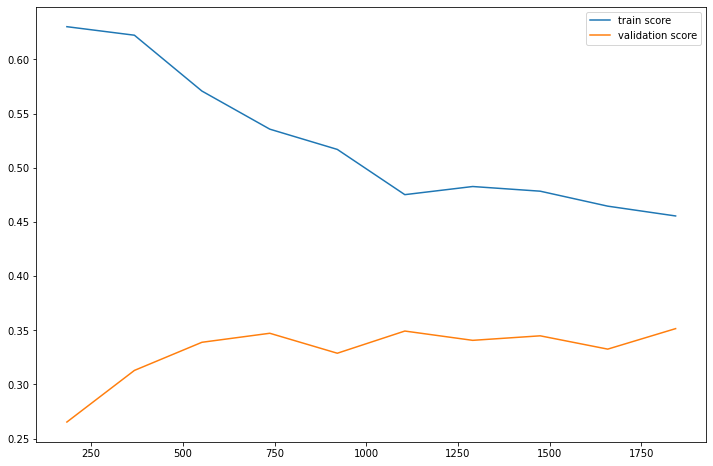

Wall time: 9min 15s


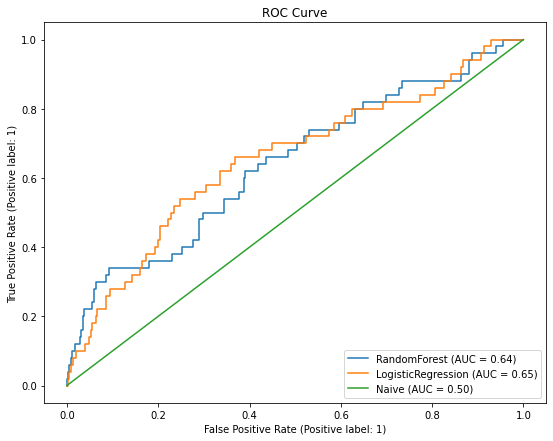

In [38]:
%%time
dic_best_model_3_1 = {}
store_score_3_1 ={}

for name, model in dic_model_3.items():
    print(name)
    grid = GridSearchCV(model,dic_params_3[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train_init,y_train)
    dic_best_model_3_1[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_3_1[name] = evaluation(grid.best_estimator_,X_test_init,y_test)
    plot_learning_curve(grid.best_estimator_,X_train_init,y_train)

plot_all_roc_curve(dic_best_model_3_1,X_test_init,y_test,naive_model=dummy_clf)

In [39]:
store_score_3_1

{'RandomForest': 0.29850746268656714,
 'LogisticRegression': 0.35714285714285715}

On observe ici une nette amélioration pour le jeu de donnée RandomForest, cependant la LogisticRegression ne semblent pas s'améliorer avec cette méthode

## 4) 10% du dataset, PolynomialFeature pour le preprocessing, et Boruta feature

In [40]:
# On garde que 10% du dataset pour faire des tests rapide un peu plus approfondi
_,new_little_dataset_2 = train_test_split(df_knowledge_domain,stratify=df_knowledge_domain["TARGET"],test_size=0.1,random_state=0)
print("Dimensionnalité du dataset :",new_little_dataset_2.shape)

Dimensionnalité du dataset : (30726, 218)


In [41]:
X_train,X_test,y_train,y_test = repartition_dataset(new_little_dataset_2,"TARGET")

Test =>
X : (6146, 217) 
y : (6146, 1)
Train =>
X : (24580, 217) 
y : (24580, 1)


In [42]:
X_train_init = X_train.copy()
X_test_init = X_test.copy()
X_train = transformer_boruta(X_train)
X_test = transformer_boruta(X_test)

In [43]:
# Preprocessor
preprocessor_4 = make_pipeline(PolynomialFeatures(include_bias=False))

# pipeline
RandomForest_4 = make_pipeline(preprocessor_4, RandomForestClassifier(random_state=0,n_jobs=50,class_weight="balanced"))
Logistic_regression_4 = make_pipeline(preprocessor_4,StandardScaler(), LogisticRegression(random_state=0,class_weight="balanced"))


dic_model_4 = {
    "RandomForest":RandomForest_4, 
    "LogisticRegression":Logistic_regression_4
}



In [44]:
dic_params_4 = {
    "RandomForest":{
        "randomforestclassifier__class_weight":['balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200],
        "pipeline__polynomialfeatures__degree":[1,2,3]
    },
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": ['balanced'],
        "logisticregression__penalty":["l1","l2"],
        "pipeline__polynomialfeatures__degree":[1,2,3]
#         "pipeline__personal_transformer__degree":[1,2,3],
#         "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    }
}

RandomForest
Best params :
 {'pipeline__polynomialfeatures__degree': 1, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 150}
Best score CV : 0.3954334794539139
Matrice confusion :
 [[4026 1624]
 [ 180  316]]
Score (fbeta 2): 0.4026503567787971


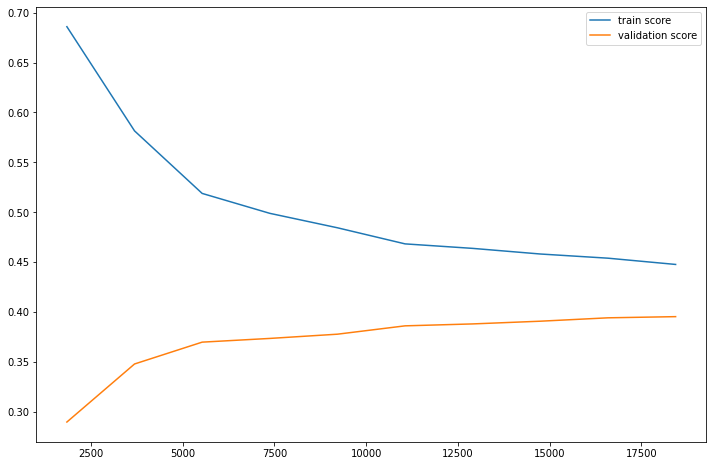

LogisticRegression
Best params :
 {'logisticregression__C': 0.046415888336127774, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'pipeline__polynomialfeatures__degree': 1}
Best score CV : 0.40640806423881903
Matrice confusion :
 [[3866 1784]
 [ 158  338]]
Score (fbeta 2): 0.4115927910375061


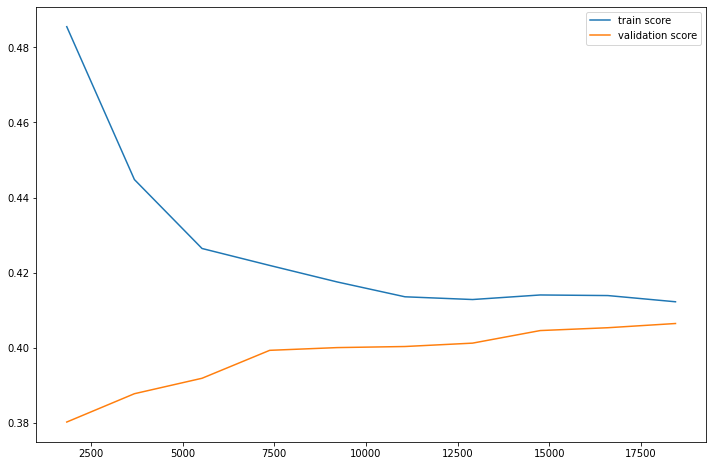

Wall time: 36min 32s


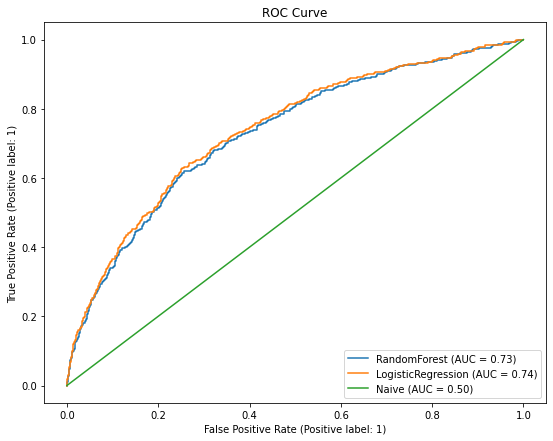

In [45]:
%%time
dic_best_model_4 = {}
store_score_4 ={}

for name, model in dic_model_4.items():
    print(name)
    grid = GridSearchCV(model,dic_params_4[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model_4[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_4[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model_4,X_test,y_test,naive_model=dummy_clf)

In [46]:
store_score_4

{'RandomForest': 0.4026503567787971, 'LogisticRegression': 0.4115927910375061}

On voir de bien meilleur résultat, ce qui semble assez cohérent avec la learning curve vu précedament.. cependant le temps de calcul ici est assez important

## 5) 10% dataset sans preprocessing et avec boruta feature

In [47]:

RandomForest_5 = make_pipeline(RandomForestClassifier(random_state=0,n_jobs=50,class_weight="balanced"))
Logistic_regression_5 = make_pipeline(StandardScaler(), LogisticRegression(random_state=0,class_weight="balanced"))


dic_model_5 = {
    "RandomForest":RandomForest_5, 
    "LogisticRegression":Logistic_regression_5
}


In [48]:
dic_params_5 = {
    "RandomForest":{
        "randomforestclassifier__class_weight":['balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200]
    },
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": ['balanced'],
        "logisticregression__penalty":["l1","l2"],
    }
}

RandomForest
Best params :
 {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 150}
Best score CV : 0.3954334794539139
Matrice confusion :
 [[4026 1624]
 [ 180  316]]
Score (fbeta 2): 0.4026503567787971


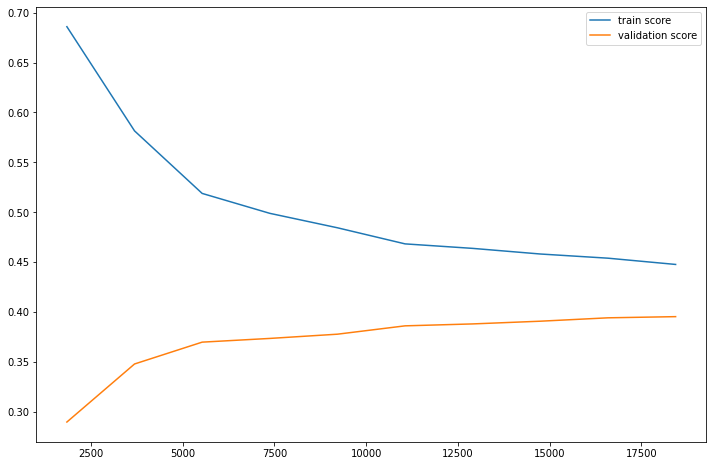

LogisticRegression
Best params :
 {'logisticregression__C': 0.046415888336127774, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}
Best score CV : 0.40640806423881903
Matrice confusion :
 [[3866 1784]
 [ 158  338]]
Score (fbeta 2): 0.4115927910375061


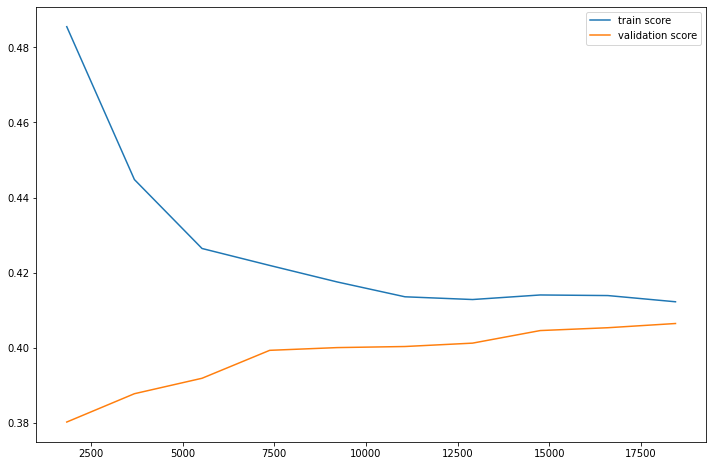

Wall time: 37.9 s


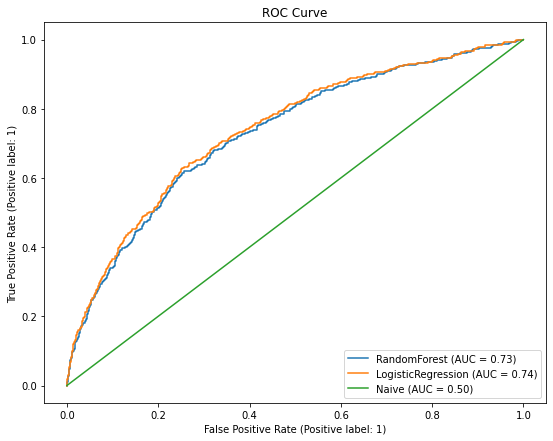

In [49]:
%%time
dic_best_model_5 = {}
store_score_5 ={}

for name, model in dic_model_5.items():
    print(name)
    grid = GridSearchCV(model,dic_params_5[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model_5[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_5[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model_5,X_test,y_test,naive_model=dummy_clf)

In [50]:
store_score_5

{'RandomForest': 0.4026503567787971, 'LogisticRegression': 0.4115927910375061}

Le résultat ici est similaire avec le PolynomialFeature en beaucoup moins de puissance de calcul nécessaire et de mémoire utilisé (nombre de colonnes multipliée avec la méthode PolynomialFeature)

## 5.1) 10% dataset sans preprocessing et avec intial feature

RandomForest
Best params :
 {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 150}
Best score CV : 0.3900442613128802
Matrice confusion :
 [[3941 1709]
 [ 179  317]]
Score (fbeta 2): 0.3952618453865337


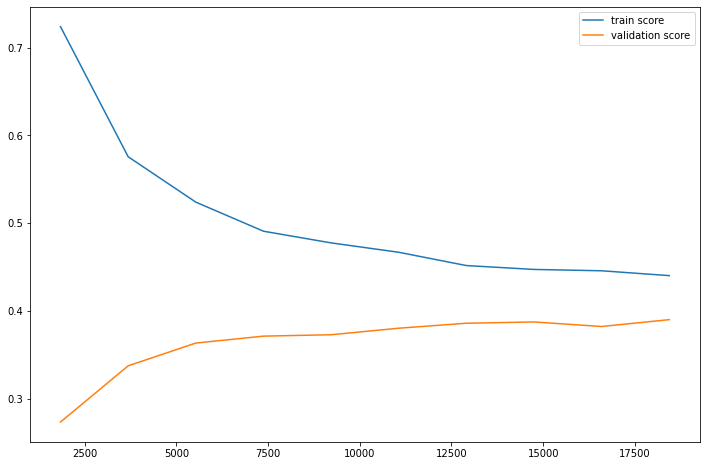

LogisticRegression
Best params :
 {'logisticregression__C': 0.0002782559402207126, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}
Best score CV : 0.4016994703298671
Matrice confusion :
 [[3882 1768]
 [ 163  333]]
Score (fbeta 2): 0.40758873929008566


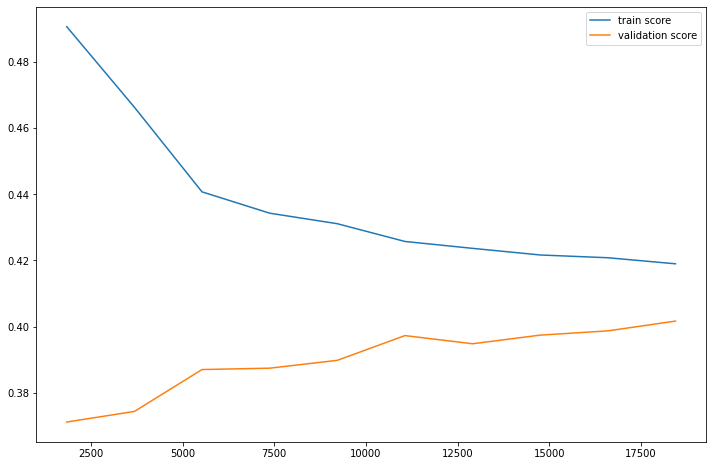

Wall time: 46.3 s


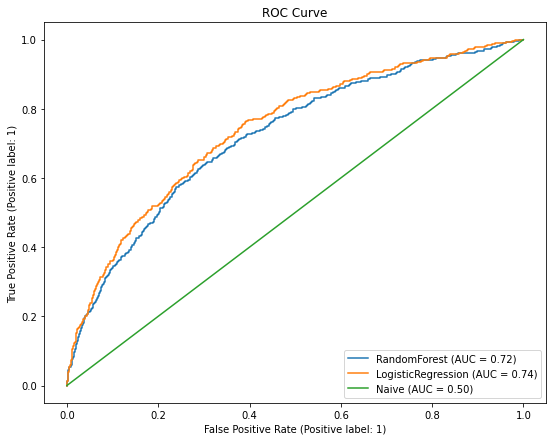

In [51]:
%%time
dic_best_model_5_1 = {}
store_score_5_1 ={}

for name, model in dic_model_5.items():
    print(name)
    grid = GridSearchCV(model,dic_params_5[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train_init,y_train)
    dic_best_model_5_1[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_5_1[name] = evaluation(grid.best_estimator_,X_test_init,y_test)
    plot_learning_curve(grid.best_estimator_,X_train_init,y_train)

plot_all_roc_curve(dic_best_model_5_1,X_test_init,y_test,naive_model=dummy_clf)

Le jeu de donnée initial sans preprocessing nous donne des résultats moindre

In [52]:
store_score_5_1

{'RandomForest': 0.3952618453865337, 'LogisticRegression': 0.40758873929008566}

## 6) 10% dataset avec preprocessing (transformer perso) et avec initial feature

In [53]:
# Preprocessor
preprocessor_6 = make_pipeline(Personal_transformer())

RandomForest_6 = make_pipeline(preprocessor_6,RandomForestClassifier(random_state=0,n_jobs=50,class_weight="balanced"))
Logistic_regression_6 = make_pipeline(preprocessor_6,StandardScaler(), LogisticRegression(random_state=0,class_weight="balanced"))


dic_model_6 = {
    "RandomForest":RandomForest_6, 
    "LogisticRegression":Logistic_regression_6
}


In [54]:
dic_params_6 = {
    "RandomForest":{
        "randomforestclassifier__class_weight":['balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200],
        "pipeline__personal_transformer__degree":[1,2,3],
        "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    },
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": ['balanced'],
        "logisticregression__penalty":["l1","l2"],
        "pipeline__personal_transformer__degree":[1,2,3],
        "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    }
}

RandomForest
Best params :
 {'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 150}
Best score CV : 0.39084097133223616
Matrice confusion :
 [[3946 1704]
 [ 183  313]]
Score (fbeta 2): 0.3911522119470132


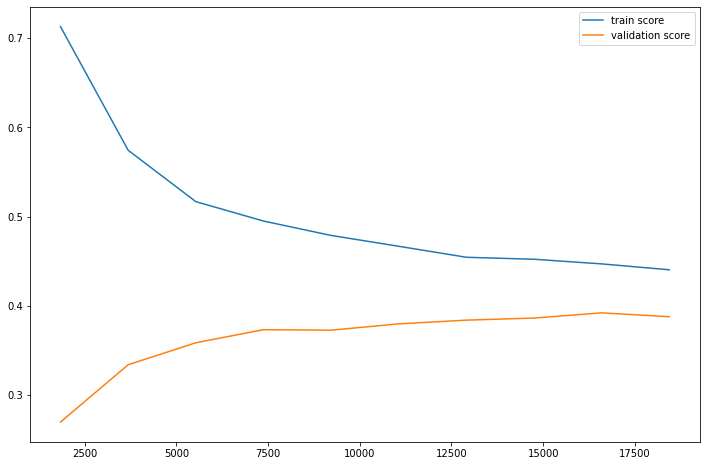

LogisticRegression
Best params :
 {'logisticregression__C': 0.0002782559402207126, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.40025263916727866
Matrice confusion :
 [[3882 1768]
 [ 163  333]]
Score (fbeta 2): 0.40758873929008566


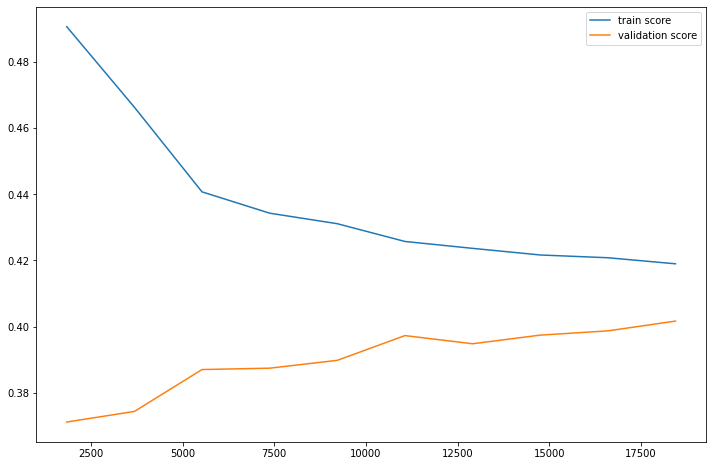

Wall time: 4min 59s


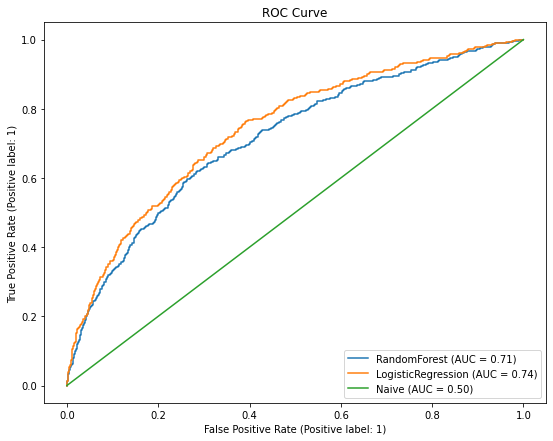

In [55]:
%%time
dic_best_model_6 = {}
store_score_6 ={}

for name, model in dic_model_6.items():
    print(name)
    grid = GridSearchCV(model,dic_params_6[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train_init,y_train)
    dic_best_model_6[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_6[name] = evaluation(grid.best_estimator_,X_test_init,y_test)
    plot_learning_curve(grid.best_estimator_,X_train_init,y_train)

plot_all_roc_curve(dic_best_model_6,X_test_init,y_test,naive_model=dummy_clf)

In [56]:
store_score_6

{'RandomForest': 0.3911522119470132, 'LogisticRegression': 0.40758873929008566}

Ici le RandomForest est moins intéressant, cependant la LogisticRegression obtient un score correct mais moins intéressant que le test 5

## 6.1) 10% dataset avec preprocessing (transformer perso) et avec boruta feature

RandomForest
Best params :
 {'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}
Best score CV : 0.3879368838508585
Matrice confusion :
 [[3968 1682]
 [ 178  318]]
Score (fbeta 2): 0.3990963855421687


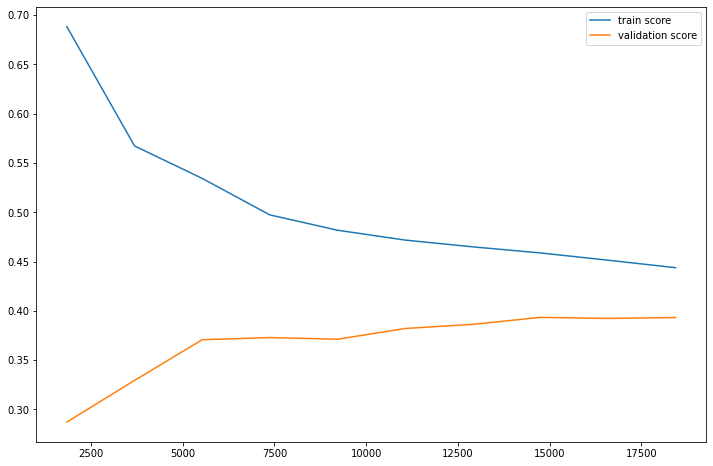

LogisticRegression
Best params :
 {'logisticregression__C': 0.0002782559402207126, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.40104927250319866
Matrice confusion :
 [[3851 1799]
 [ 156  340]]
Score (fbeta 2): 0.4123211253941305


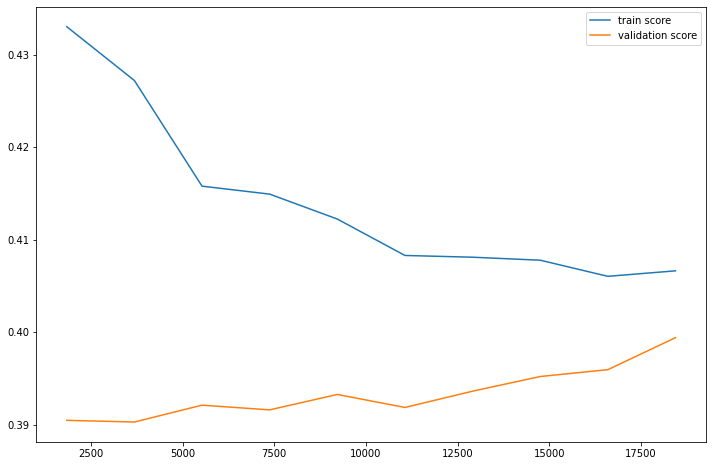

Wall time: 3min 35s


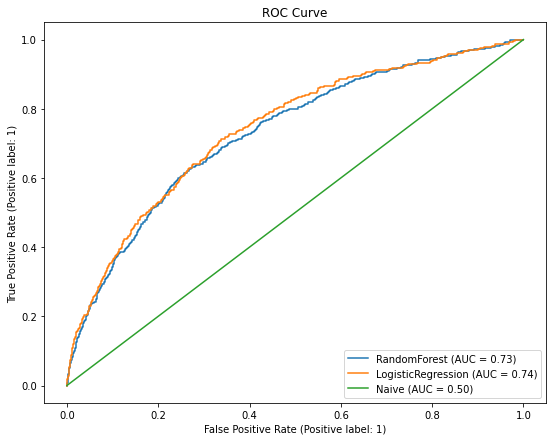

In [57]:
%%time
dic_best_model_6_1 = {}
store_score_6_1 ={}

for name, model in dic_model_6.items():
    print(name)
    grid = GridSearchCV(model,dic_params_6[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model_6_1[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_6_1[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model_6_1,X_test,y_test,naive_model=dummy_clf)

In [58]:
store_score_6_1

{'RandomForest': 0.3990963855421687, 'LogisticRegression': 0.4123211253941305}

Ce test obtient le meileur résutlat pour la **LogisticRegression avec 0.412 de score FBeta2**

## 7) 10% dataset, over_sampling, personnal_transformer, boruta feature

In [82]:
# On garde que 10% du dataset pour faire des tests rapide un peu plus approfondi
_,new_little_dataset_2 = train_test_split(df_knowledge_domain,stratify=df_knowledge_domain["TARGET"],test_size=0.1,random_state=0)
print("Dimensionnalité du dataset :",new_little_dataset_2.shape)

Dimensionnalité du dataset : (30726, 218)


In [83]:
X_train,X_test,y_train,y_test = repartition_dataset(new_little_dataset_2,"TARGET",over_sampling=True)

Test =>
X : (6146, 217) 
y : (6146, 1)
Train =>
X : (6777, 217) 
y : (6777, 1)


In [84]:
round(y_train["TARGET"].value_counts(normalize=True)*100,3)

0    66.667
1    33.333
Name: TARGET, dtype: float64

In [85]:
X_train_init = X_train.copy()
X_test_init = X_test.copy()
X_train = transformer_boruta(X_train)
X_test = transformer_boruta(X_test)

In [87]:
# Preprocessor
preprocessor_7 = make_pipeline(Personal_transformer())

RandomForest_7 = make_pipeline(preprocessor_7,RandomForestClassifier(random_state=0,n_jobs=50))
Logistic_regression_7 = make_pipeline(preprocessor_7,StandardScaler(), LogisticRegression(random_state=0))


dic_model_7 = {
    "RandomForest":RandomForest_7, 
    "LogisticRegression":Logistic_regression_7
}


In [89]:

dic_params_7 = {
    "RandomForest":{
        "randomforestclassifier__class_weight":[{0:1,1:1},{0:1,1:2},{0:1,1:5},'balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200],
        "pipeline__personal_transformer__degree":[1,2,3],
        "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    },
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": [{0:1,1:1},{0:1,1:2},{0:1,1:5},'balanced'],
        "logisticregression__penalty":["l1","l2"],
        "pipeline__personal_transformer__degree":[1,2,3],
        "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    }
}

RandomForest
Best params :
 {'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5, 'randomforestclassifier__class_weight': {0: 1, 1: 5}, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}
Best score CV : 0.7269096375440869
Matrice confusion :
 [[ 689 4961]
 [  18  478]]
Score (fbeta 2): 0.32197224841708205


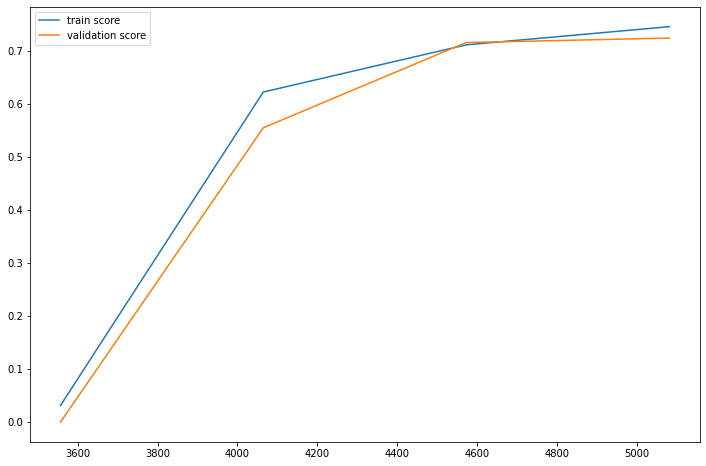

LogisticRegression
Best params :
 {'logisticregression__C': 0.000774263682681127, 'logisticregression__class_weight': {0: 1, 1: 5}, 'logisticregression__penalty': 'l2', 'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.731168621310163
Matrice confusion :
 [[1212 4438]
 [  31  465]]
Score (fbeta 2): 0.3375925657034994


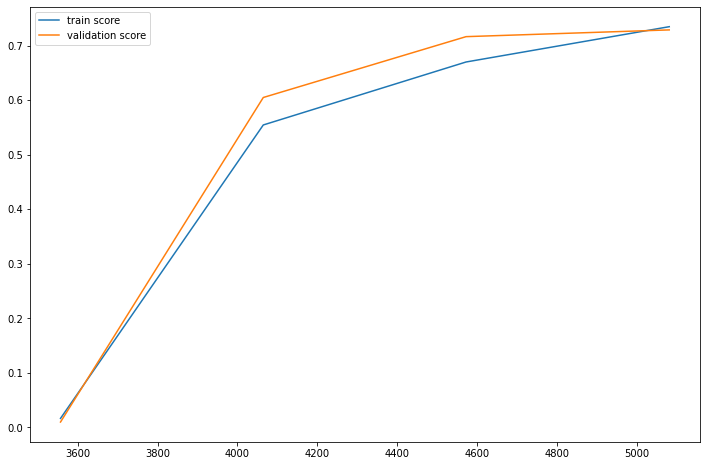

Wall time: 3min 28s


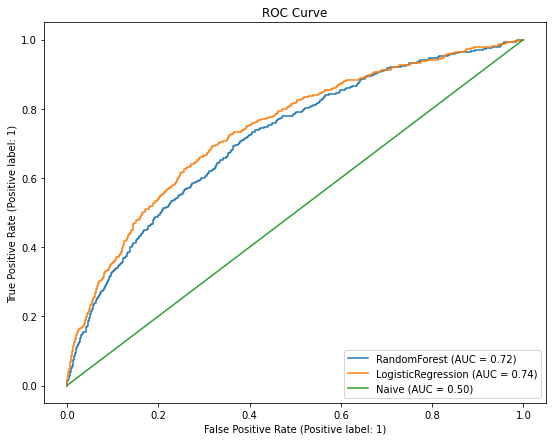

In [90]:
%%time
dic_best_model_7 = {}
store_score_7 ={}

for name, model in dic_model_7.items():
    print(name)
    grid = GridSearchCV(model,dic_params_7[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model_7[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_7[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model_7,X_test,y_test,naive_model=dummy_clf)

## 7.1) 10% dataset, over_sampling, personnal_transformer, initial_feature

RandomForest
Best params :
 {'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5, 'randomforestclassifier__class_weight': {0: 1, 1: 5}, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 50}
Best score CV : 0.7271219343983293
Matrice confusion :
 [[ 329 5321]
 [   8  488]]
Score (fbeta 2): 0.313101501347363


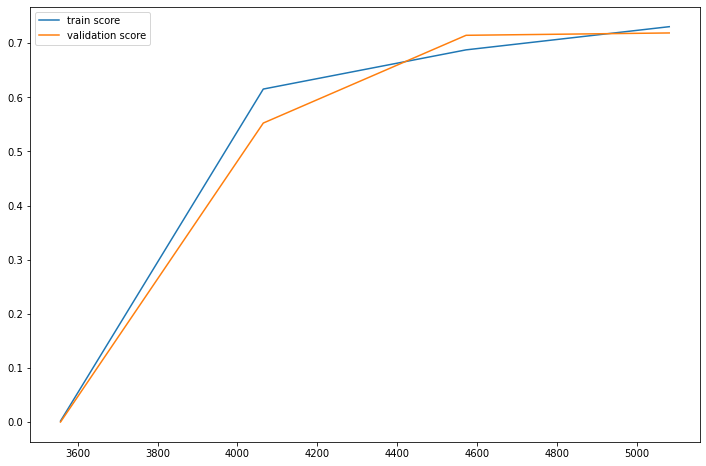

LogisticRegression
Best params :
 {'logisticregression__C': 0.0002782559402207126, 'logisticregression__class_weight': {0: 1, 1: 5}, 'logisticregression__penalty': 'l2', 'pipeline__personal_transformer__degree': 1, 'pipeline__personal_transformer__n_best': 5}
Best score CV : 0.7317274686375738
Matrice confusion :
 [[ 827 4823]
 [  17  479]]
Score (fbeta 2): 0.3287125995059017


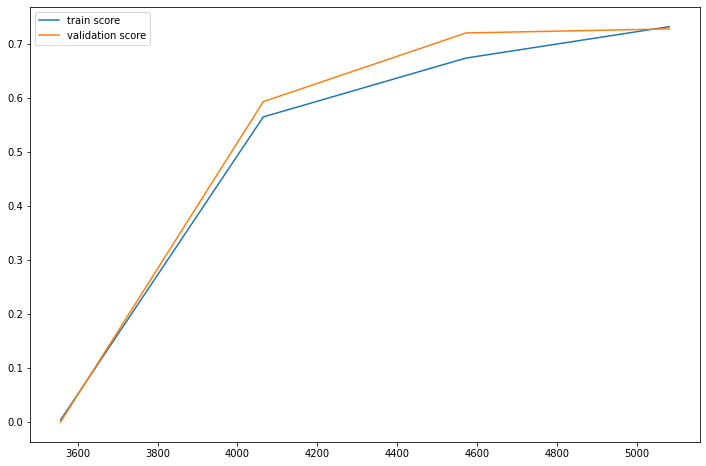

Wall time: 4min 43s


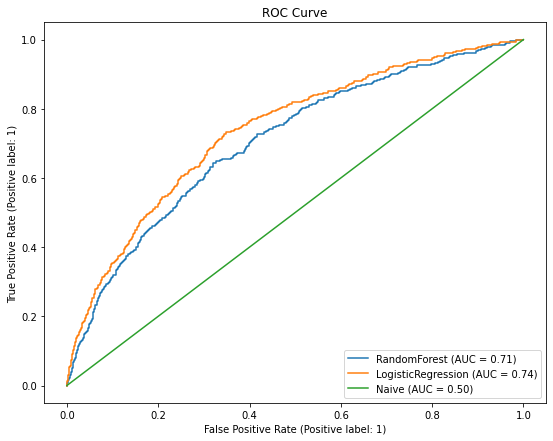

In [91]:
%%time
dic_best_model_7_1 = {}
store_score_7_1 ={}

for name, model in dic_model_7.items():
    print(name)
    grid = GridSearchCV(model,dic_params_7[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train_init,y_train)
    dic_best_model_7_1[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_7_1[name] = evaluation(grid.best_estimator_,X_test_init,y_test)
    plot_learning_curve(grid.best_estimator_,X_train_init,y_train)

plot_all_roc_curve(dic_best_model_7_1,X_test_init,y_test,naive_model=dummy_clf)

## 8) 10% dataset, over_sampling, without transformer, boruta_feature

In [93]:
# Preprocessor

RandomForest_8 = make_pipeline(RandomForestClassifier(random_state=0,n_jobs=50))
Logistic_regression_8 = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))


dic_model_8 = {
    "RandomForest":RandomForest_8, 
    "LogisticRegression":Logistic_regression_8
}

In [94]:
dic_params_8 = {
    "RandomForest":{
        "randomforestclassifier__class_weight":[{0:1,1:1},{0:1,1:2},{0:1,1:5},'balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200]
    },
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": [{0:1,1:1},{0:1,1:2},{0:1,1:5},'balanced'],
        "logisticregression__penalty":["l1","l2"]
    }
}

RandomForest
Best params :
 {'randomforestclassifier__class_weight': {0: 1, 1: 5}, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 200}
Best score CV : 0.7240678123892618
Matrice confusion :
 [[ 713 4937]
 [  17  479]]
Score (fbeta 2): 0.3236486486486487


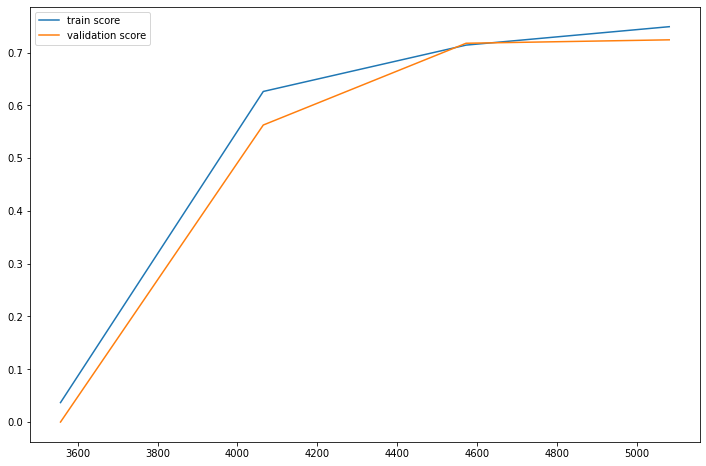

LogisticRegression
Best params :
 {'logisticregression__C': 0.000774263682681127, 'logisticregression__class_weight': {0: 1, 1: 5}, 'logisticregression__penalty': 'l2'}
Best score CV : 0.728626925527785
Matrice confusion :
 [[1212 4438]
 [  31  465]]
Score (fbeta 2): 0.3375925657034994


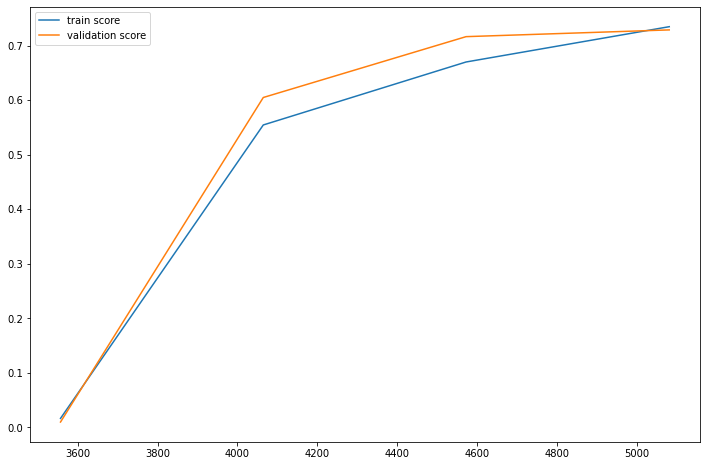

Wall time: 24.7 s


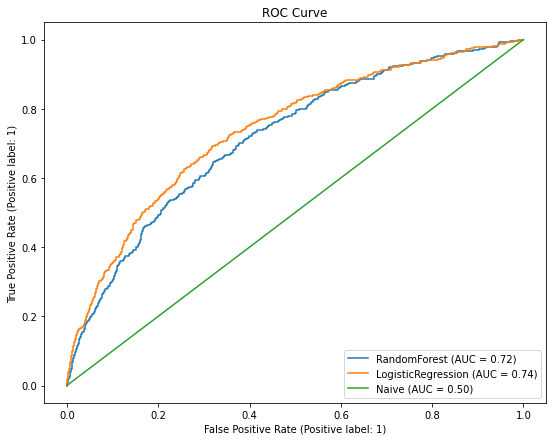

In [95]:
%%time
dic_best_model_8 = {}
store_score_8 ={}

for name, model in dic_model_8.items():
    print(name)
    grid = GridSearchCV(model,dic_params_8[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model_8[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_8[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model_8,X_test,y_test,naive_model=dummy_clf)

## 8.1) 10% dataset, over_sampling, without transformer, intial feature

RandomForest
Best params :
 {'randomforestclassifier__class_weight': {0: 1, 1: 5}, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 50}
Best score CV : 0.7220037640708591
Matrice confusion :
 [[ 380 5270]
 [   9  487]]
Score (fbeta 2): 0.3145588425268053


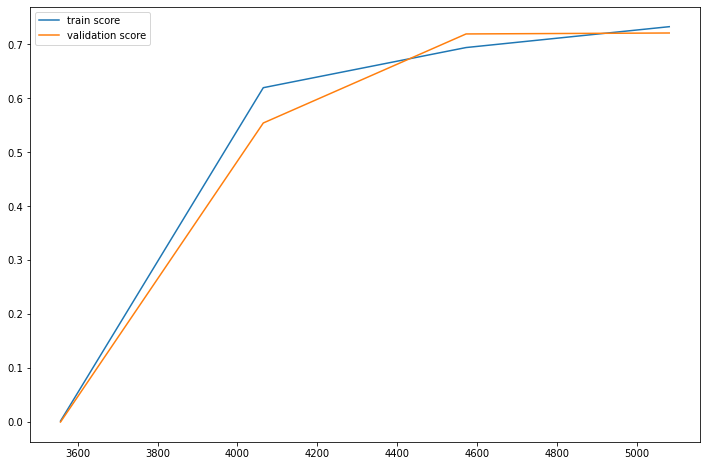

LogisticRegression
Best params :
 {'logisticregression__C': 0.0002782559402207126, 'logisticregression__class_weight': {0: 1, 1: 5}, 'logisticregression__penalty': 'l2'}
Best score CV : 0.7276982434458035
Matrice confusion :
 [[ 827 4823]
 [  17  479]]
Score (fbeta 2): 0.3287125995059017


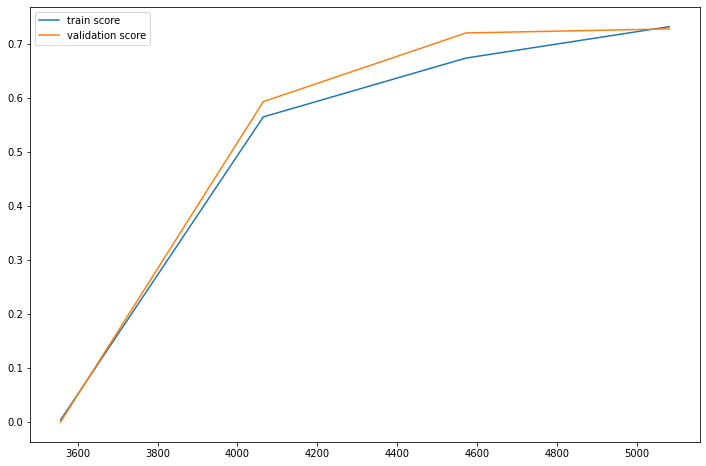

Wall time: 25 s


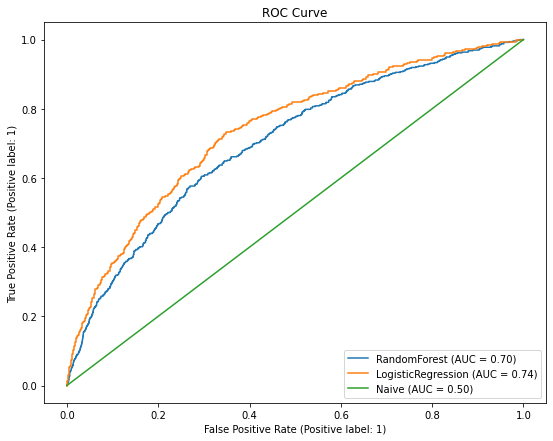

In [96]:
%%time
dic_best_model_8_1 = {}
store_score_8_1 ={}

for name, model in dic_model_8.items():
    print(name)
    grid = GridSearchCV(model,dic_params_8[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train_init,y_train)
    dic_best_model_8_1[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_8_1[name] = evaluation(grid.best_estimator_,X_test_init,y_test)
    plot_learning_curve(grid.best_estimator_,X_train_init,y_train)

plot_all_roc_curve(dic_best_model_8_1,X_test_init,y_test,naive_model=dummy_clf)

## 9) 10% dataset, undersampling, without transformer, boruta feature

In [97]:
X_train,X_test,y_train,y_test = repartition_dataset(new_little_dataset_2,"TARGET",under_sampling=True)

Test =>
X : (6146, 217) 
y : (6146, 1)
Train =>
X : (3970, 217) 
y : (3970, 1)


In [98]:
round(y_train["TARGET"].value_counts(normalize=True)*100,3)

0    50.0
1    50.0
Name: TARGET, dtype: float64

In [99]:
X_train_init = X_train.copy()
X_test_init = X_test.copy()
X_train = transformer_boruta(X_train)
X_test = transformer_boruta(X_test)

In [100]:

RandomForest_9 = make_pipeline(RandomForestClassifier(random_state=0,n_jobs=50))
Logistic_regression_9 = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))


dic_model_9 = {
    "RandomForest":RandomForest_9, 
    "LogisticRegression":Logistic_regression_9
}

dic_params_9 = {
    "RandomForest":{
        "randomforestclassifier__class_weight":[{0:1,1:1},{0:1,1:2},{0:1,1:5},'balanced'],
        "randomforestclassifier__max_depth": [5,10,20,50,100,200],
        "randomforestclassifier__n_estimators":[50,100,150,200],
#         "pipeline__personal_transformer__degree":[1,2,3],
#         "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    },
    "LogisticRegression":{
        "logisticregression__C":np.logspace(-4, 0, 10),
        "logisticregression__class_weight": [{0:1,1:1},{0:1,1:2},{0:1,1:5},'balanced'],
        "logisticregression__penalty":["l1","l2"],
#         "pipeline__personal_transformer__degree":[1,2,3],
#         "pipeline__personal_transformer__n_best":[5,10,20,50,100]
    }
}

RandomForest
Best params :
 {'randomforestclassifier__class_weight': {0: 1, 1: 5}, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 200}
Best score CV : 0.8349489486745987
Matrice confusion :
 [[  68 5582]
 [   1  495]]
Score (fbeta 2): 0.3070338667659099


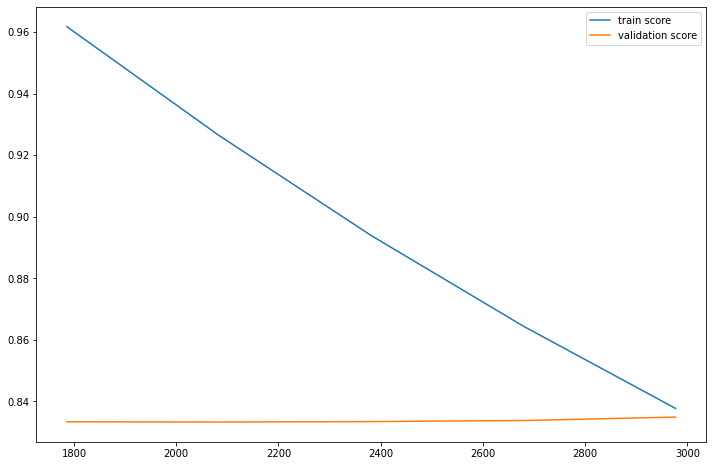

LogisticRegression
Best params :
 {'logisticregression__C': 0.005994842503189409, 'logisticregression__class_weight': {0: 1, 1: 5}, 'logisticregression__penalty': 'l2'}
Best score CV : 0.8354637911739491
Matrice confusion :
 [[ 404 5246]
 [  10  486]]
Score (fbeta 2): 0.3149300155520995


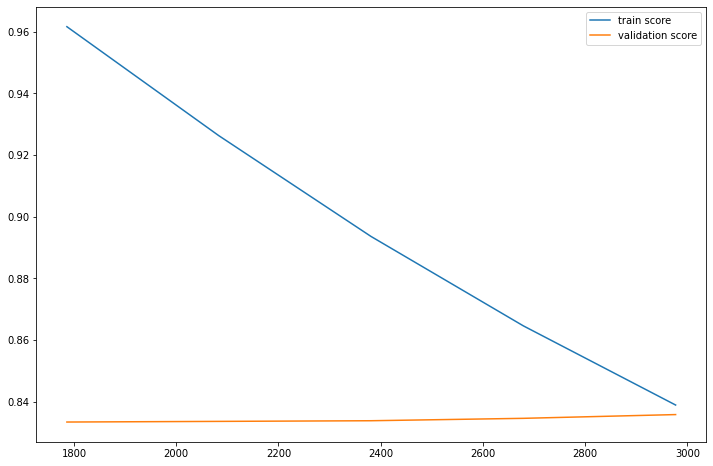

Wall time: 22.5 s


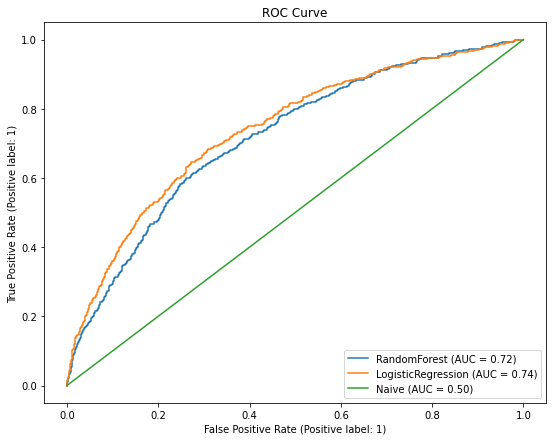

In [101]:
%%time
dic_best_model_9 = {}
store_score_9 ={}

for name, model in dic_model_9.items():
    print(name)
    grid = GridSearchCV(model,dic_params_9[name],scoring=ftwo_scorer,cv=4,n_jobs=30)
    grid.fit(X_train,y_train)
    dic_best_model_9[name] = grid.best_estimator_
    print("Best params :\n",grid.best_params_)
    print("Best score CV :",grid.best_score_)
    store_score_9[name] = evaluation(grid.best_estimator_,X_test,y_test)
    plot_learning_curve(grid.best_estimator_,X_train,y_train)

plot_all_roc_curve(dic_best_model_9,X_test,y_test,naive_model=dummy_clf)

Les méthodes d'over et under sampling ne permettent pas une amélioration des différent modèles.

# Synthèse des modèles selectionnés

**Le test n°6.1** semble être le meilleur pour la **LogisticRegression avec 0.412 de score FBeta2** pour la RandomForest le meilleur contexte était pour le **test n°5 avec un score de 0.403**

## LogisticRegression :

In [59]:
X_train,X_test,y_train,y_test = repartition_dataset(df_knowledge_domain,"TARGET")

Test =>
X : (61451, 217) 
y : (61451, 1)
Train =>
X : (245803, 217) 
y : (245803, 1)


In [60]:
X_test = transformer_boruta(X_test)
X_train = transformer_boruta(X_train)

In [80]:
dic_best_model_6_1["LogisticRegression"]

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('personal_transformer',
                                  Personal_transformer(degree=1, n_best=5))])),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0002782559402207126,
                                    class_weight='balanced', random_state=0))])

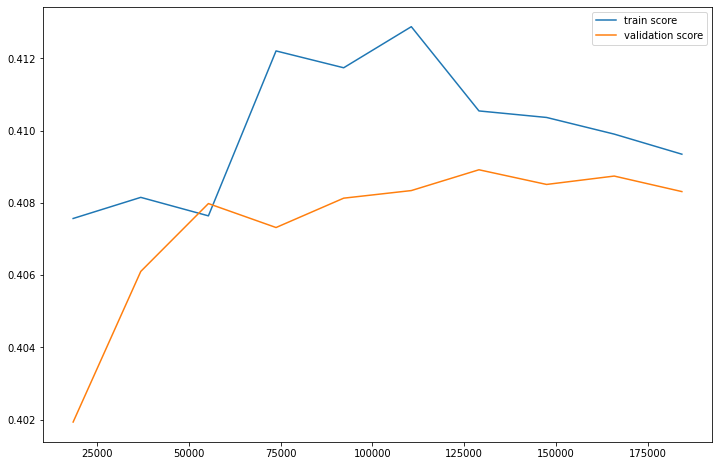

In [81]:
plot_learning_curve(dic_best_model_6_1["LogisticRegression"],X_train,y_train)

In [63]:
best_model_LR = dic_best_model_6_1["LogisticRegression"]
best_model_LR.fit(X_train,y_train)
evaluation(best_model_LR,X_test,y_test)

Matrice confusion :
 [[38628 17861]
 [ 1644  3318]]
Score (fbeta 2): 0.40436785531479275


0.40436785531479275

## RandomForest :

In [65]:
dic_best_model_5["RandomForest"]

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=150, n_jobs=50,
                                        random_state=0))])

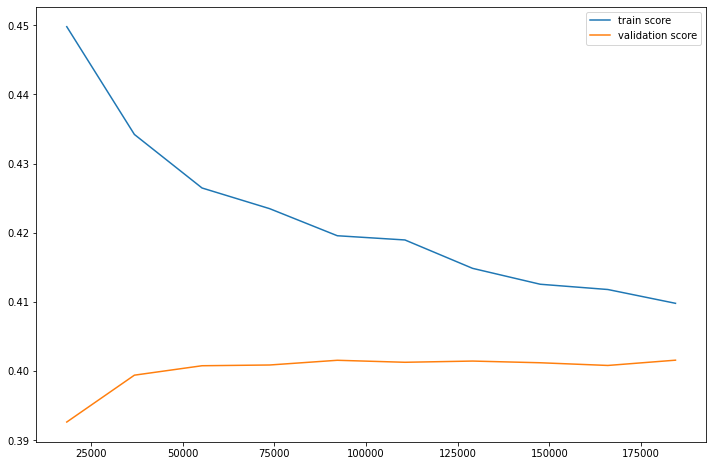

In [66]:
plot_learning_curve(dic_best_model_5["RandomForest"],X_train,y_train)

In [67]:
best_model_RF = dic_best_model_5["RandomForest"]
best_model_RF.fit(X_train,y_train)
evaluation(best_model_RF,X_test,y_test)

Matrice confusion :
 [[38262 18227]
 [ 1654  3308]]
Score (fbeta 2): 0.3996810284416306


0.3996810284416306

Pour la suite on continuera l'optimisation du modèle avec le RandomForest qui semble ici être le modèle le plus prometteur (learning curve qui semble tendre vers 0.41 score contre 0.405 pour le LogisticRegression voir moin car les courbes sembles décroitre )